Exploring the $\chi^2$ distribution
===

Start with some model to generate random data.  <br> 
We'll use $0.2+\frac{sin(x)}{x+1}$ over the range $0\leq x<15$ <br>
Generate $N$ random numbers according to this distribution and make a histogram of the results using 30 bins. 

An easy way to generate random numbers according to an arbitrary distribution is to use rejection sampling (here's a great [decription  of the technique](https://matthewfeickert.github.io/Statistics-Notes/notebooks/simulation/Rejection-Sampling-MC.html) )

1) Make a histogram of your random distribution.  Verify that the the numbers you generated agree with the shape of the function.  Generate at least 10000 points and plot your data in a histogram with errorbars.  You can use numpy+matplotlib+etc, PyROOT, or a mix.  Think about how to appropriately normalize your function, then overlay it with the data.  The normalization depends on the number of bins, the bin range and the number of points thrown.  You may find it easier to first nromalize the area of your function to 1.0, thus turning it into a proper PDF.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
import pandas as pd

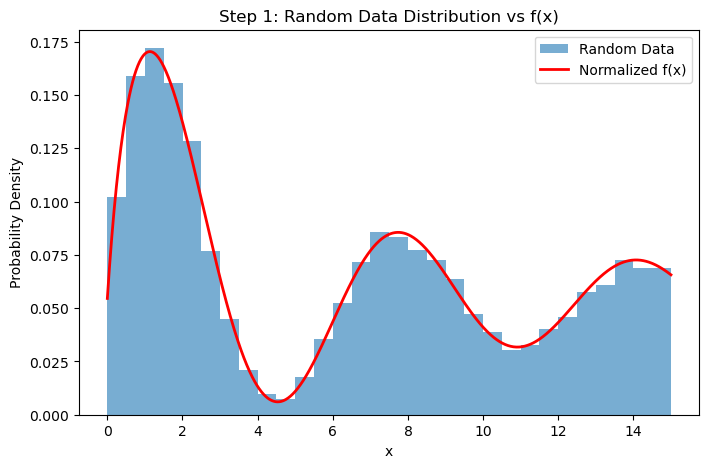

In [2]:
# Target function
def f(x):
    return 0.2 + np.sin(x) / (x + 1)

xmin, xmax = 0, 15
N = 10000  # number of points
nbins = 30  # number of bins

# Rejection sampling setup
x_vals = np.linspace(xmin, xmax, 1000)
f_max = f(x_vals).max()

def generate_random_data(N=10000):
    """Generate random data following f(x) using rejection sampling."""
    samples = []
    while len(samples) < N:
        x_trial = np.random.uniform(xmin, xmax, size=N)
        y_trial = np.random.uniform(0, f_max, size=N)
        mask = y_trial < f(x_trial)
        samples.extend(x_trial[mask])
    return np.array(samples[:N])

# Generate dataset
data = generate_random_data(N)

# Normalize function for comparison
f_norm = f(x_vals) / np.trapz(f(x_vals), x_vals)

# Plot histogram with normalized function
plt.figure(figsize=(8, 5))
plt.hist(data, bins=nbins, density=True, alpha=0.6, label='Random Data')
plt.plot(x_vals, f_norm, 'r-', lw=2, label='Normalized f(x)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Step 1: Random Data Distribution vs f(x)')
plt.legend()
plt.show()


2) Repeat the above experiment at least 1000 times.  For each experiment calculate the $\chi^2$ of your data with respect to your (properly normalized) model.  Plot (histogram) the $\chi^2$ distribution and compare it to the functional form of the $\chi^2(ndof=30)$ distribution.  You can find the form of the $\chi^2(ndof)$ PDF function in many places and implement it using the Gamma function or use a premade function, eg:
* [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution)
* [scipy.stats.chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2)

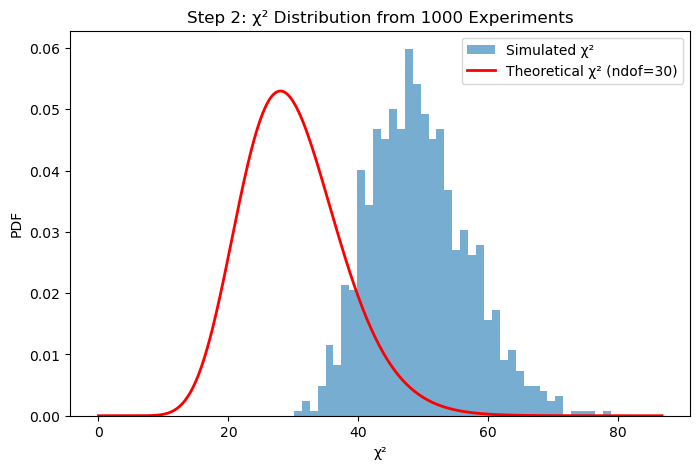

Mean χ² = 49.37 (Expected ≈ 30)


In [3]:
def chi_square_value(model_func, data, bins):
    """Compute χ² comparing data histogram to model."""
    counts, edges = np.histogram(data, bins=bins, range=(xmin, xmax))
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    bin_width = edges[1] - edges[0]
    
    # Expected counts from model
    model_vals = model_func(bin_centers)
    model_vals /= np.trapz(model_vals, bin_centers)
    expected = model_vals * len(data) * bin_width
    
    observed = counts
    mask = expected > 0
    chi2_val = np.sum((observed[mask] - expected[mask])**2 / expected[mask])
    return chi2_val

ndof = nbins
n_experiments = 1000
chi2_values = []

for _ in range(n_experiments):
    data = generate_random_data(N)
    chi2_values.append(chi_square_value(f, data, nbins))

# Plot χ² histogram vs theoretical χ² PDF
plt.figure(figsize=(8, 5))
plt.hist(chi2_values, bins=40, density=True, alpha=0.6, label='Simulated χ²')
x = np.linspace(0, max(chi2_values)*1.1, 400)
plt.plot(x, chi2.pdf(x, ndof), 'r-', lw=2, label=f'Theoretical χ² (ndof={ndof})')
plt.xlabel('χ²')
plt.ylabel('PDF')
plt.title('Step 2: χ² Distribution from 1000 Experiments')
plt.legend()
plt.show()

print(f"Mean χ² = {np.mean(chi2_values):.2f} (Expected ≈ {ndof})")


**Only required for Phys5630**

3) Modify your code above to perform the following study. <br>
Repeat (2) for nbins = $ndof = 30, 50, 75, 100$ and calculate the reduced $\chi^2$, eg $\chi^2/ndof$ for each experiment.  Plot the mean value of the reduced $\chi^2$ with errorbars versus $ndof$.  Make a table comparing your calculations to the expected results.

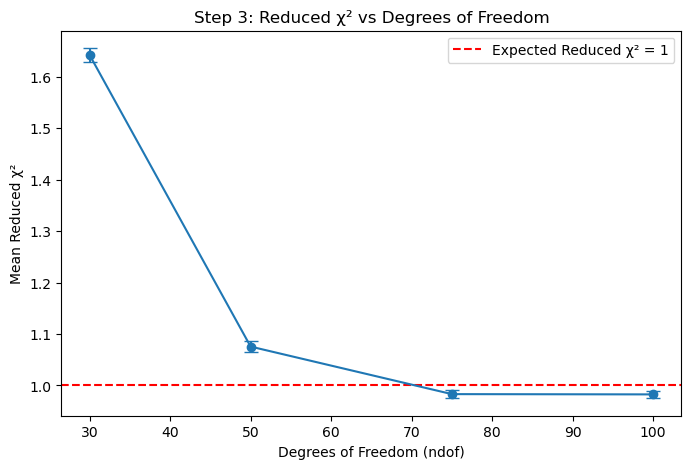


Comparison Table:
 ndof  Mean Reduced χ²  Error
   30            1.642  0.013
   50            1.076  0.010
   75            0.983  0.008
  100            0.983  0.007


In [4]:
ndof_list = [30, 50, 75, 100]
mean_reduced = []
err_reduced = []

for ndof in ndof_list:
    chi2_vals = []
    for _ in range(400):
        data = generate_random_data(N)
        chi2_val = chi_square_value(f, data, ndof)
        chi2_vals.append(chi2_val / ndof)
    chi2_vals = np.array(chi2_vals)
    mean_reduced.append(np.mean(chi2_vals))
    err_reduced.append(np.std(chi2_vals) / np.sqrt(len(chi2_vals)))

# Plot reduced χ² vs ndof
plt.figure(figsize=(8, 5))
plt.errorbar(ndof_list, mean_reduced, yerr=err_reduced, fmt='o-', capsize=5)
plt.axhline(1, color='r', linestyle='--', label='Expected Reduced χ² = 1')
plt.xlabel('Degrees of Freedom (ndof)')
plt.ylabel('Mean Reduced χ²')
plt.title('Step 3: Reduced χ² vs Degrees of Freedom')
plt.legend()
plt.show()

# Output results table
results = pd.DataFrame({
    'ndof': ndof_list,
    'Mean Reduced χ²': np.round(mean_reduced, 3),
    'Error': np.round(err_reduced, 3)
})
print('\nComparison Table:')
print(results.to_string(index=False))